In [1]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import train_test_split

from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

from itertools import cycle
from scipy import linalg
import matplotlib as mpl

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [2]:
marathon_download = pd.read_csv('https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2014/results.csv')

In [3]:
pd.set_option("display.max_columns",None)
marathon_download.head()


,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,35k,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,71.40,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,116.37,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,67.42,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,116.37,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,67.83,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [5]:
df3 = marathon_download.copy()

In [75]:
df = marathon_download.copy()
df = df.sample(frac=1)
df = df[['gender','10k', 'division', '25k', 'age', 'official', 'genderdiv', '35k', 'overall', 'pace',
         '30k', '5k', '20k', '40k','half','country']]
df['gender'] = df['gender'].map({'M': 1, 'F': 0})

In [8]:
df2 = df[['gender','10k', 'division', '25k', 'age', 'official', 'genderdiv', '35k', 'overall', 'pace',
         '30k', '5k', '20k', '40k','half']]

In [9]:
df2 = df2.convert_objects(convert_numeric=True)
df2.dtypes

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


gender         int64
10k          float64
division       int64
25k          float64
age            int64
official     float64
genderdiv      int64
35k          float64
overall        int64
pace         float64
30k          float64
5k           float64
20k          float64
40k          float64
half         float64
dtype: object

### So first, I did a correlation map to see if there was any redundancy... Basically, all of the 'times', pace, and genderdiv overlapped quite a bit. So, I took them out for now... 

             gender       10k  division       25k       age  official  \
gender     1.000000 -0.274295 -0.125786 -0.264457  0.208802 -0.204402   
10k       -0.274295  1.000000  0.471512  0.973560  0.168110  0.927890   
division  -0.125786  0.471512  1.000000  0.497113 -0.577256  0.515368   
25k       -0.264457  0.973560  0.497113  1.000000  0.158788  0.967845   
age        0.208802  0.168110 -0.577256  0.158788  1.000000  0.166440   
official  -0.204402  0.927890  0.515368  0.967845  0.166440  1.000000   
genderdiv  0.166793  0.798911  0.470752  0.825818  0.306829  0.878360   
35k       -0.229902  0.945407  0.511247  0.984319  0.157434  0.993262   
overall   -0.246634  0.902533  0.514493  0.928007  0.201129  0.954233   
pace      -0.204713  0.927988  0.515633  0.967875  0.166593  0.999897   
30k       -0.247670  0.960637  0.501272  0.995389  0.157009  0.981801   
5k        -0.270774  0.990603  0.470086  0.951203  0.160136  0.904570   
20k       -0.270965  0.986372  0.481538  0.995084  

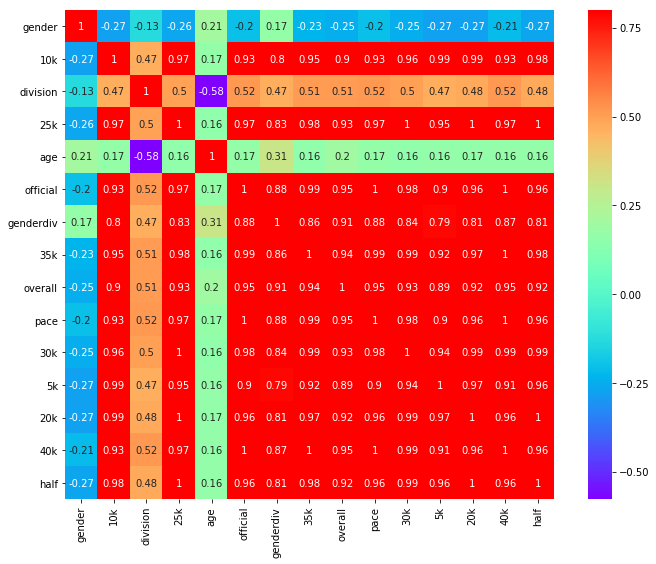

In [10]:
# Make the correlation matrix.
corrmat = df2.corr()
print(corrmat)

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn.
sns.heatmap(corrmat, vmax=.8, square=True, annot=True, cmap = 'rainbow')
plt.show()
# Heatmaps are a great way to get a quick visual read on a big correlation matrix.

# Try to match the correlation numbers to the scatterplots above to get a 
# sense of what each magnitude of correlation can look like.


In [11]:
df3 = df[['gender', 'division', 'age', 'official']]

### Division is basically their placement within their division. According to this, there are 23 1st place runners, so there must be 23 different divisions. 

In [12]:
df3.division[df3.division == 1].count()

23

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


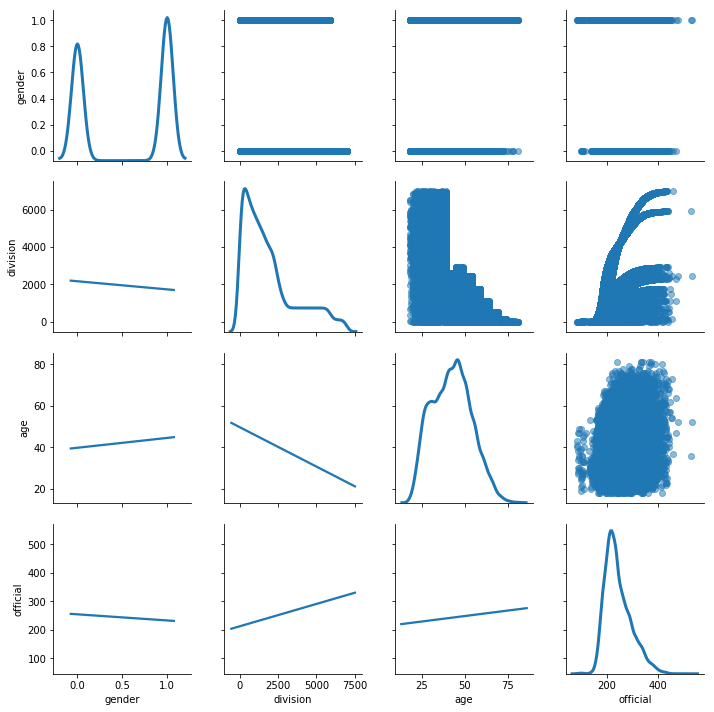

In [13]:
# Declare that you want to make a scatterplot matrix.
g = sns.PairGrid(df3.dropna(), diag_sharey=False)
# Scatterplot.
g.map_upper(plt.scatter, alpha=.5)
# Fit line summarizing the linear relationship of the two variables.
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
# Give information about the univariate distributions of the variables.
g.map_diag(sns.kdeplot, lw=3)
plt.show()

### The explained variance function allowed me to see that the first 2 PCAs account for 99% of the variance... so I'll stick with 2 PCAs... 

In [38]:
# Normalize the data.
X = df3.dropna()
X_norm = normalize(X)

pca = PCA(n_components = None)
# Reduce it to two components.
X_pca = pca.fit_transform(X_norm)

explained_variance = pca.explained_variance_ratio_

explained_variance

array([  9.58625953e-01,   3.96236536e-02,   1.74427447e-03,
         6.11850952e-06])

### Interesting plot, I wonder what it means... lol

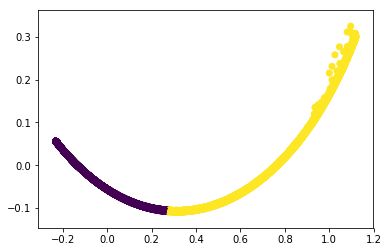

In [39]:
# Normalize the data.
X = df3.dropna()
X_norm = normalize(X)

# Reduce it to two components.
X_pca = PCA(2).fit_transform(X_norm)

# Calculate predicted values.
y_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X_norm)

# # Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

### I took the predictions and put it back into the original DataFrame to see how it would cluster...

In [40]:
X['prediction'] = y_pred

In [41]:
X.head()

,gender,division,age,official,prediction
19564,0,329,52,230.37,1
2208,1,505,41,185.57,0
4814,1,2724,32,195.28,0
846,1,807,28,171.35,0
21573,0,92,60,261.43,1


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


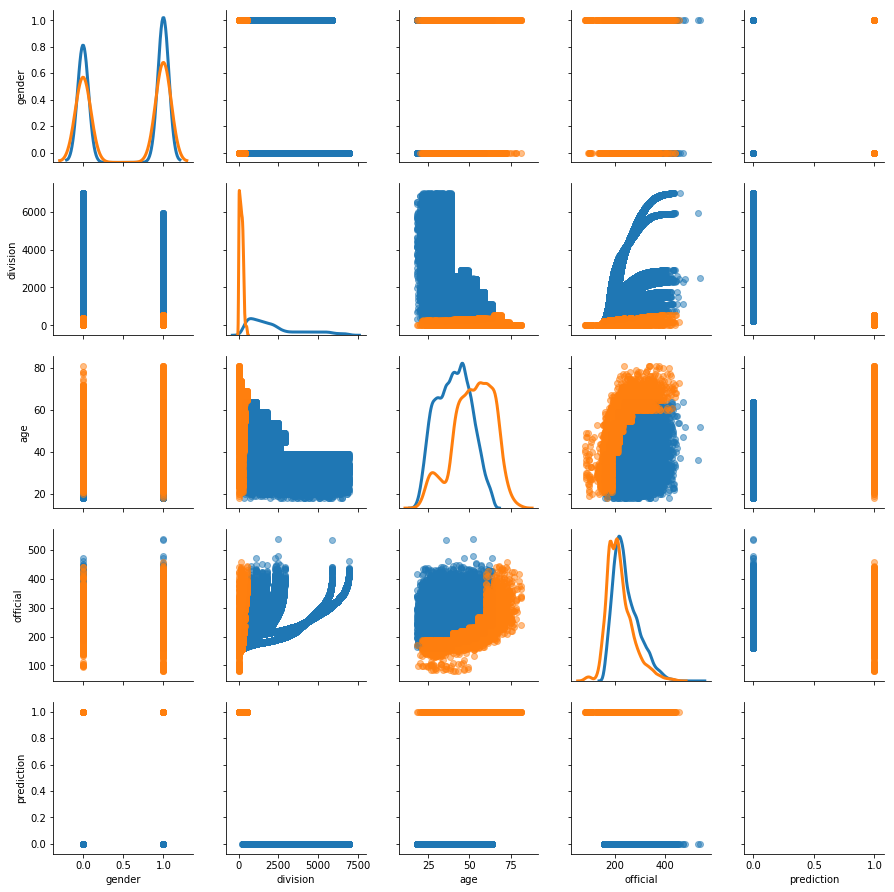

In [42]:
# Declare that you want to make a scatterplot matrix.
g = sns.PairGrid(X, hue='prediction', diag_sharey=False)
# Scatterplot.
g.map_upper(plt.scatter, alpha=.5)
# Fit line summarizing the linear relationship of the two variables.
g.map_lower(plt.scatter, alpha=.5)
# Give information about the univariate distributions of the variables.
g.map_diag(sns.kdeplot, lw=3)
plt.show()

In [43]:
X_1 = X.loc[X.prediction == 0]
X_1.describe()

,gender,division,age,official,prediction
count,27187.000000,27187.00000,27187.000000,27187.000000,27187.0
mean,0.552727,2244.20039,40.633391,246.808823,0.0
std,0.497221,1676.69898,10.201189,51.368515,0.0
min,0.000000,240.00000,18.000000,159.080000,0.0
25%,0.000000,954.00000,32.000000,208.950000,0.0
50%,1.000000,1717.00000,41.000000,235.450000,0.0
75%,1.000000,3047.00000,48.000000,277.610000,0.0
max,1.000000,6979.00000,64.000000,538.880000,0.0


In [44]:
X_2 = X.loc[X.prediction == 1]
X_2.describe()

,gender,division,age,official,prediction
count,4797.000000,4797.000000,4797.000000,4797.000000,4797.0
mean,0.539921,166.358141,52.459454,221.395589,1.0
std,0.498456,113.028336,12.050797,52.292030,0.0
min,0.000000,1.000000,18.000000,80.600000,1.0
25%,0.000000,72.000000,45.000000,184.030000,1.0
50%,1.000000,154.000000,54.000000,211.270000,1.0
75%,1.000000,246.000000,62.000000,248.530000,1.0
max,1.000000,537.000000,81.000000,457.550000,1.0


### I'm going to repeat the above with 3 clusters instead of 2...

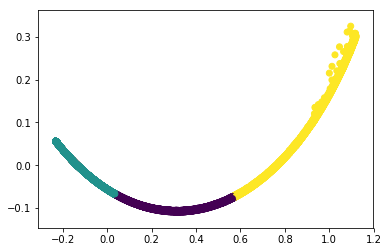

In [45]:
# Normalize the data.
X = df3.dropna()
X_norm = normalize(X)

# Reduce it to two components.
X_pca = PCA(2).fit_transform(X_norm)

# Calculate predicted values.
y_pred = KMeans(n_clusters=3, random_state=42).fit_predict(X_norm)

# # Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


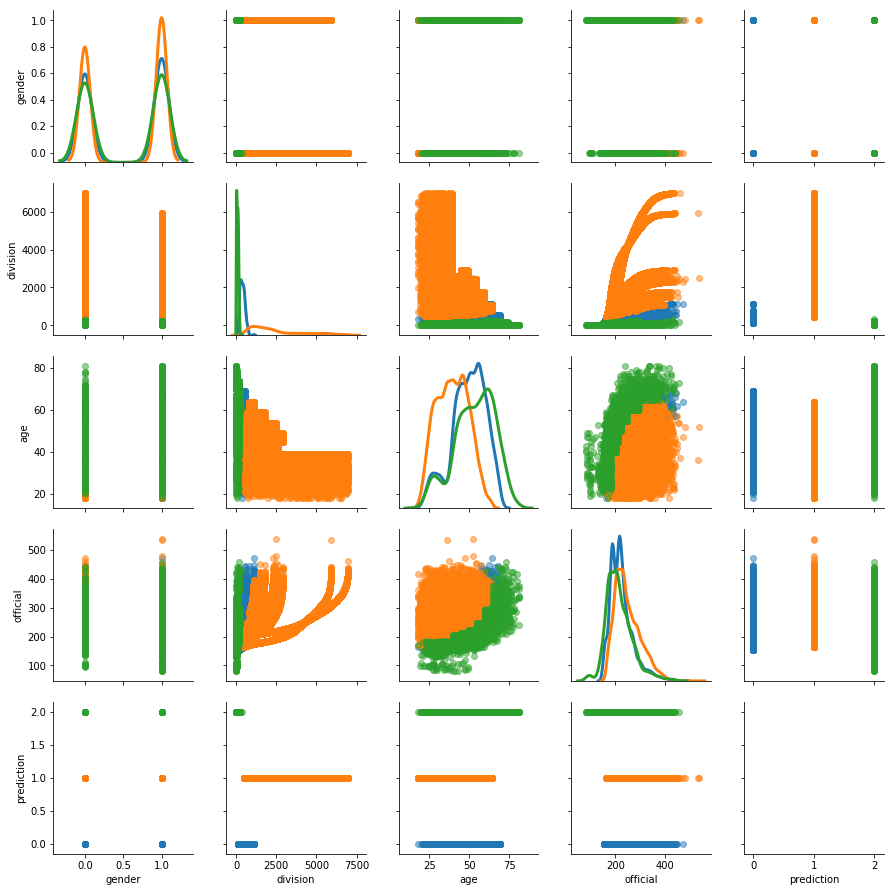

In [46]:
X['prediction'] = y_pred

# Declare that you want to make a scatterplot matrix.
g = sns.PairGrid(X, hue='prediction', diag_sharey=False)
# Scatterplot.
g.map_upper(plt.scatter, alpha=.5)
# Fit line summarizing the linear relationship of the two variables.
g.map_lower(plt.scatter, alpha=.5)
# Give information about the univariate distributions of the variables.
g.map_diag(sns.kdeplot, lw=3)
plt.show()

In [47]:
X_1 = X.loc[X.prediction == 0]
X_1.describe()

,gender,division,age,official,prediction
count,5343.000000,5343.000000,5343.000000,5343.000000,5343.0
mean,0.540146,397.510949,49.585252,225.585772,0.0
std,0.498432,148.111138,10.569367,46.683112,0.0
min,0.000000,126.000000,18.000000,154.280000,0.0
25%,0.000000,278.500000,43.000000,191.790000,0.0
50%,1.000000,385.000000,51.000000,217.270000,0.0
75%,1.000000,499.500000,57.000000,245.510000,0.0
max,1.000000,1112.000000,69.000000,473.170000,0.0


In [48]:
X_2 = X.loc[X.prediction == 1]
X_2.describe()

,gender,division,age,official,prediction
count,23949.000000,23949.000000,23949.000000,23949.000000,23949.0
mean,0.556182,2482.628878,39.580275,249.899062,1.0
std,0.496844,1646.854807,9.777103,51.525654,0.0
min,0.000000,454.000000,18.000000,164.750000,1.0
25%,0.000000,1206.000000,32.000000,210.630000,1.0
50%,1.000000,1939.000000,40.000000,238.200000,1.0
75%,1.000000,3452.000000,47.000000,282.080000,1.0
max,1.000000,6979.000000,64.000000,538.880000,1.0


In [49]:
X_3 = X.loc[X.prediction == 2]
X_3.describe()

,gender,division,age,official,prediction
count,2692.000000,2692.000000,2692.000000,2692.000000,2692.0
mean,0.524146,85.704309,53.308321,216.154785,2.0
std,0.499509,55.919411,12.541453,53.012997,0.0
min,0.000000,1.000000,18.000000,80.600000,2.0
25%,0.000000,37.000000,45.000000,178.827500,2.0
50%,1.000000,82.000000,55.000000,207.000000,2.0
75%,1.000000,127.000000,63.000000,244.172500,2.0
max,1.000000,341.000000,81.000000,457.550000,2.0


### I don't think the above endeavor prooved to be fruitful... I'm going to repeat the above but without taking out any of the features and letting the PCA do the reduction...

In [19]:
df2.head()

,gender,10k,division,25k,age,official,genderdiv,35k,overall,pace,30k,5k,20k,40k,half
19564,0,52.60,329,132.35,52,230.37,5385,189.77,15399,8.80,160.65,26.13,105.35,218.12,111.13
2208,1,42.60,505,106.47,41,185.57,3087,150.75,3319,7.08,127.97,20.97,84.88,175.13,89.47
4814,1,42.93,2724,106.63,32,195.28,4730,152.88,5346,7.45,129.13,21.48,85.18,182.60,89.82
846,1,38.70,807,100.17,28,171.35,1021,142.02,1076,6.55,120.92,19.03,79.70,162.78,84.12
21573,0,57.32,92,146.00,60,261.43,9171,208.62,22088,9.98,176.60,28.10,116.18,244.10,122.55


### According to this pca explained variances, the first 3 PCAs explain almost 100% of the variance. So, I'll try it again with 3 PCAs... 

In [22]:
# Normalize the data.
X = df2.dropna()
X_norm = normalize(X)

pca = PCA(n_components = None)
# Reduce it to two components.
X_pca = pca.fit_transform(X_norm)

explained_variance = pca.explained_variance_ratio_

explained_variance

array([  5.57241165e-01,   2.77686416e-01,   1.58830132e-01,
         5.97535867e-03,   2.28334093e-04,   3.12612353e-05,
         5.54552308e-06,   7.54784934e-07,   3.93909782e-07,
         2.68919999e-07,   2.23327578e-07,   8.05636538e-08,
         5.82011065e-08,   7.66160249e-09,   8.92771707e-11])

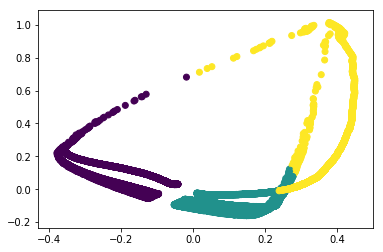

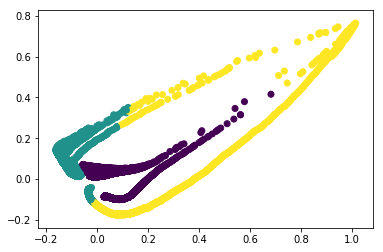

In [59]:
# Normalize the data.
X = df2.dropna()
X_norm = normalize(X)

# Reduce it to two components.
X_pca = PCA(3).fit_transform(X_norm)

# Calculate predicted values.
y_pred = KMeans(n_clusters=3, random_state=42).fit_predict(X_pca)

# # Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

# # Plot the solution.
plt.scatter(X_pca[:, 1], X_pca[:, 2], c=y_pred)
plt.show()

In [60]:
X_pca_df = pd.DataFrame(data=X_pca, columns= ['pca_1','pca_2','pca_3']) 

In [61]:
X_pca_df['prediction'] = y_pred

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


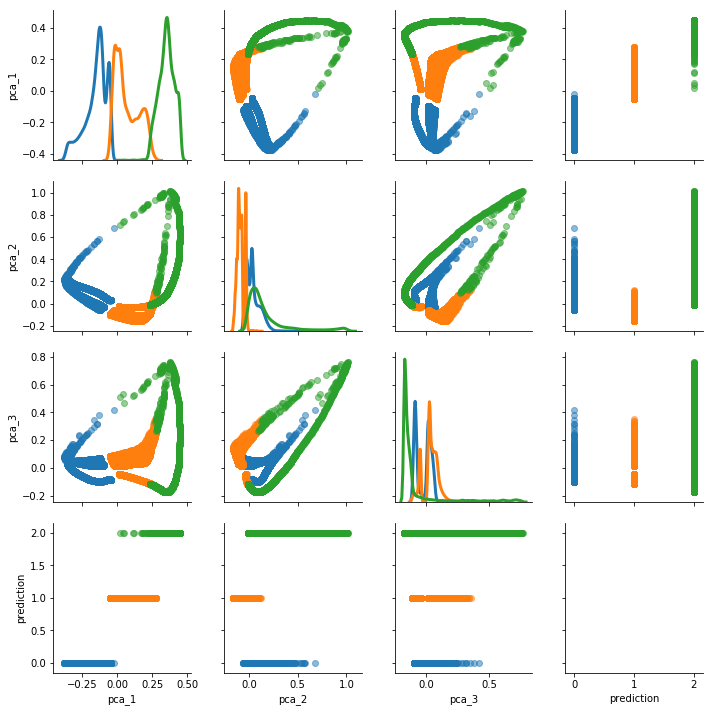

In [62]:
# Declare that you want to make a scatterplot matrix.
g = sns.PairGrid(X_pca_df,hue='prediction', diag_sharey=False)
# Scatterplot.
g.map_upper(plt.scatter, alpha=.5)
# Fit line summarizing the linear relationship of the two variables.
g.map_lower(plt.scatter, alpha=.5)
# Give information about the univariate distributions of the variables.
g.map_diag(sns.kdeplot, lw=3)
plt.show()

In [63]:
X['prediction'] = y_pred

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [64]:
X.head()

,gender,10k,division,25k,age,official,genderdiv,35k,overall,pace,30k,5k,20k,40k,half,prediction
19564,0,52.60,329,132.35,52,230.37,5385,189.77,15399,8.80,160.65,26.13,105.35,218.12,111.13,0
2208,1,42.60,505,106.47,41,185.57,3087,150.75,3319,7.08,127.97,20.97,84.88,175.13,89.47,1
4814,1,42.93,2724,106.63,32,195.28,4730,152.88,5346,7.45,129.13,21.48,85.18,182.60,89.82,2
846,1,38.70,807,100.17,28,171.35,1021,142.02,1076,6.55,120.92,19.03,79.70,162.78,84.12,2
21573,0,57.32,92,146.00,60,261.43,9171,208.62,22088,9.98,176.60,28.10,116.18,244.10,122.55,0


In [65]:
X_1 = X.loc[X.prediction == 0]
X_1.describe()

,gender,10k,division,25k,age,official,genderdiv,35k,overall,pace,30k,5k,20k,40k,half,prediction
count,14128.0,14128.000000,14128.000000,14128.000000,14128.000000,14128.000000,14128.000000,14128.000000,14128.000000,14128.000000,14128.000000,14128.000000,14128.000000,14128.000000,14128.000000,14128.0
mean,0.0,54.376259,2162.732022,141.277039,39.789071,253.855069,7130.137528,206.761737,18393.651897,9.690503,173.231891,26.991968,111.292972,239.811383,117.505446,0.0
std,0.0,7.730229,1945.094452,23.391623,10.495427,46.240919,4104.306934,37.274298,7750.798986,1.763713,30.114651,3.681879,17.419620,43.797347,18.451788,0.0
min,0.0,36.470000,1.000000,91.980000,18.000000,158.800000,27.000000,131.770000,291.000000,6.070000,111.850000,18.180000,73.280000,150.630000,77.320000,0.0
25%,0.0,48.700000,620.000000,124.227500,31.000000,219.280000,3573.750000,179.380000,12199.750000,8.370000,151.150000,24.245000,98.600000,207.180000,104.050000,0.0
50%,0.0,52.720000,1476.000000,135.570000,40.000000,241.815000,7127.500000,196.970000,18451.000000,9.230000,165.520000,26.250000,107.120000,228.200000,113.080000,0.0
75%,0.0,59.000000,3376.250000,153.935000,47.000000,280.840000,10684.250000,227.335000,24912.750000,10.720000,189.550000,29.320000,121.055000,264.885000,127.800000,0.0
max,0.0,91.080000,6979.000000,240.020000,81.000000,461.870000,14355.000000,365.620000,31926.000000,17.620000,309.570000,48.830000,187.620000,433.280000,198.450000,0.0


In [66]:
X_1 = X.loc[X.prediction == 1]
X_1.describe()

,gender,10k,division,25k,age,official,genderdiv,35k,overall,pace,30k,5k,20k,40k,half,prediction
count,14250.0,14250.000000,14250.000000,14250.000000,14250.000000,14250.000000,14250.000000,14250.000000,14250.000000,14250.000000,14250.000000,14250.000000,14250.000000,14250.000000,14250.000000,14250.0
mean,1.0,51.587197,1786.982456,133.510714,47.357404,244.994065,10176.533754,197.263468,16347.265123,9.352405,164.252811,25.677582,105.156705,230.670366,111.068295,1.0
std,0.0,8.189324,1543.353525,24.153121,10.543264,49.462133,4410.272853,39.334478,8915.827607,1.886414,31.413663,3.999062,17.961753,46.693546,19.067483,0.0
min,1.0,32.120000,1.000000,82.230000,18.000000,163.550000,466.000000,132.600000,498.000000,6.250000,109.230000,15.680000,65.150000,153.680000,68.730000,1.0
25%,1.0,45.180000,585.000000,115.220000,41.000000,207.480000,6771.250000,167.520000,8513.250000,7.920000,140.520000,22.550000,91.420000,195.250000,96.500000,1.0
50%,1.0,49.710000,1349.000000,127.420000,47.000000,233.280000,10345.500000,187.325000,16183.000000,8.900000,156.220000,24.780000,100.780000,219.220000,106.450000,1.0
75%,1.0,56.920000,2400.000000,147.380000,55.000000,275.865000,13925.750000,220.722500,24264.000000,10.530000,182.365000,28.427500,115.745000,259.300000,122.227500,1.0
max,1.0,112.380000,5911.000000,289.020000,81.000000,538.880000,17575.000000,449.330000,31931.000000,20.570000,376.380000,86.950000,224.350000,508.350000,236.670000,1.0


In [67]:
X_1 = X.loc[X.prediction == 2]
X_1.describe()

,gender,10k,division,25k,age,official,genderdiv,35k,overall,pace,30k,5k,20k,40k,half,prediction
count,3271.000000,3271.000000,3271.000000,3271.000000,3271.000000,3271.000000,3271.000000,3271.000000,3271.000000,3271.000000,3271.000000,3271.000000,3271.000000,3271.000000,3271.000000,3271.0
mean,0.988688,39.945616,1477.667686,100.648407,31.935799,177.291688,2303.359523,144.336891,2542.012840,6.770293,122.007475,20.007093,80.246695,167.189560,84.650572,2.0
std,0.105769,3.833832,937.187939,9.050954,5.424898,16.887938,1710.058781,13.025911,1975.206597,0.644250,10.899264,2.024034,7.272231,15.745942,7.665623,0.0
min,0.000000,16.620000,1.000000,45.800000,18.000000,80.600000,1.000000,67.420000,1.000000,3.080000,56.450000,7.750000,36.100000,76.100000,38.030000,2.0
25%,1.000000,38.240000,654.500000,96.370000,28.000000,168.790000,804.500000,138.010000,849.500000,6.450000,116.635000,19.140000,76.880000,159.340000,81.080000,2.0
50%,1.000000,40.630000,1472.000000,102.150000,32.000000,179.020000,2026.000000,146.280000,2143.000000,6.830000,123.820000,20.380000,81.430000,169.080000,85.880000,2.0
75%,1.000000,42.320000,2289.500000,106.180000,36.000000,188.750000,3566.500000,152.600000,3879.500000,7.200000,128.660000,21.220000,84.775000,177.825000,89.420000,2.0
max,1.000000,51.200000,3111.000000,122.780000,59.000000,204.000000,6182.000000,170.480000,7489.000000,7.780000,146.330000,27.350000,97.770000,193.750000,103.280000,2.0


### What's interesting about these clusters is that there was a definite cluster by gender. Cluster 0 was all female, while cluster 1 was all male. Culster 2 was mostly male except for a small precentage of females. This cluster is the youngest and also had the lowest mean official time at 177 minutes.

### I'm going to try it again and include country this time... maybe something interesting will come out of it...

In [84]:
df = marathon_download.copy()
df = df.sample(frac=1)
df = df[['gender','10k', 'division', '25k', 'age', 'official', 'genderdiv', '35k', 'overall', 'pace',
         '30k', '5k', '20k', '40k','half','country']]
df['gender'] = df['gender'].map({'M': 1, 'F': 0})
df4 = df.convert_objects(convert_numeric=True)
df4.dtypes

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:6: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  


gender         int64
10k          float64
division       int64
25k          float64
age            int64
official     float64
genderdiv      int64
35k          float64
overall        int64
pace         float64
30k          float64
5k           float64
20k          float64
40k          float64
half         float64
country       object
dtype: object

In [93]:
df4_dummies = pd.get_dummies(df4)

In [95]:
df4_dummies.head()

,gender,10k,division,25k,age,official,genderdiv,35k,overall,pace,30k,5k,20k,40k,half,country_ARG,country_AUS,country_AUT,country_BAH,country_BAR,country_BEL,country_BER,country_BLR,country_BOL,country_BRA,country_BRN,country_CAN,country_CAY,country_CHI,country_CHN,country_COL,country_CRC,country_CRO,country_CZE,country_DEN,country_DOM,country_ECU,country_EGY,country_ESA,country_ESP,country_EST,country_ETH,country_FIN,country_FRA,country_GBR,country_GER,country_GRE,country_GUA,country_HKG,country_HUN,country_INA,country_IND,country_IRL,country_ISL,country_ISR,country_ITA,country_JPN,country_KEN,country_KOR,country_LIE,country_LUX,country_MAR,country_MAS,country_MEX,country_NED,country_NOR,country_NZL,country_PAN,country_PER,country_PHI,country_POL,country_POR,country_QAT,country_ROU,country_RSA,country_RUS,country_SIN,country_SLO,country_SUI,country_SVK,country_SWE,country_TAN,country_THA,country_TPE,country_TRI,country_TUR,country_UAE,country_UKR,country_URU,country_USA,country_VEN,country_VGB,country_ZIM
27326,0,50.05,1300,122.03,24,207.03,1688,172.97,8380,7.90,147.37,25.58,97.77,196.77,102.93,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
29238,0,68.63,6237,182.82,24,324.22,12861,266.88,29162,12.37,226.27,33.25,144.25,307.40,152.40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
30463,1,61.18,2631,154.68,45,296.25,15155,233.25,26835,11.30,191.93,30.03,122.75,277.60,129.25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
29457,1,62.80,1680,172.83,56,336.92,16681,265.92,29930,12.87,221.83,31.35,128.73,316.78,135.92,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
6429,1,43.33,2342,108.18,36,189.45,3686,154.72,4024,7.23,130.80,21.68,86.48,179.15,91.15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


### Once again, the first 3 PCAs account for almost 100% of the variance...

In [97]:
# Normalize the data.
X = df4_dummies.dropna()
X_norm = normalize(X)

pca = PCA(n_components = None)
# Reduce it to two components.
X_pca = pca.fit_transform(X_norm)

explained_variance = pca.explained_variance_ratio_

explained_variance

array([  5.57240531e-01,   2.77686095e-01,   1.58829799e-01,
         5.97544888e-03,   2.28364908e-04,   3.12635696e-05,
         5.55576154e-06,   7.68125143e-07,   5.04864984e-07,
         3.99726774e-07,   2.41989027e-07,   2.24960848e-07,
         1.23896388e-07,   9.07962039e-08,   7.75889008e-08,
         6.54285360e-08,   5.82930667e-08,   5.54764005e-08,
         3.92215923e-08,   3.54144007e-08,   3.15505237e-08,
         2.77376389e-08,   2.43760212e-08,   2.22010531e-08,
         2.09374459e-08,   1.55056347e-08,   1.34482422e-08,
         1.24455002e-08,   9.81640898e-09,   8.34600435e-09,
         8.14792821e-09,   7.53104449e-09,   6.74408194e-09,
         6.68652620e-09,   5.52942701e-09,   4.95865670e-09,
         4.24317351e-09,   3.86332012e-09,   3.78371552e-09,
         2.79335108e-09,   2.40536187e-09,   1.85968316e-09,
         1.46848347e-09,   1.29234850e-09,   1.05643438e-09,
         8.03981360e-10,   5.27382104e-10,   5.15487070e-10,
         5.00891575e-10,

### The plots look the same... So no new incite is given with countries... 

In [ ]:
# Normalize the data.
X = df4_dummies.dropna()
X_norm = normalize(X)

# Reduce it to two components.
X_pca = PCA(3).fit_transform(X_norm)

# Calculate predicted values.
y_pred = KMeans(n_clusters=3, random_state=42).fit_predict(X_pca)

# # Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

# # Plot the solution.
plt.scatter(X_pca[:, 1], X_pca[:, 2], c=y_pred)
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


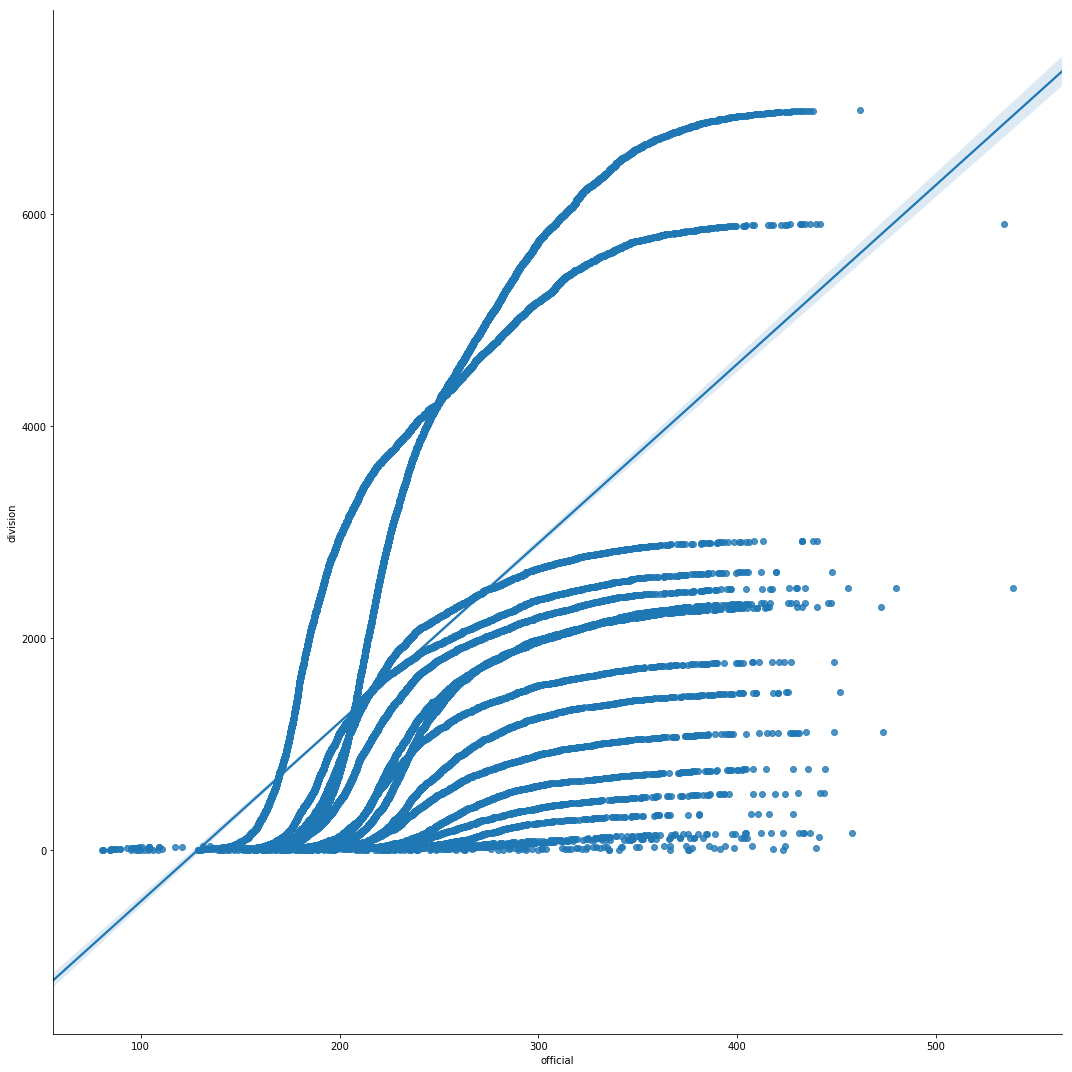

In [18]:
sns.lmplot('official','division', data = X, size= 15)
plt.show()

In [104]:
# Make sure the number of rows divides evenly into four samples.
rows = df2.shape[0] - df2.shape[0] % 4
df2 = df2.iloc[:rows, :]

X = df2.dropna()
# Normalize
# X_norm = normalize(X)

# Data frame to store features and predicted cluster memberships.
ypred = pd.DataFrame()

# Create the two-feature PCA for graphing purposes.
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X_norm)

# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2 = train_test_split(
    X,
    test_size=0.5,
    random_state=42)

# Then we halve the halves.
X1, X2 = train_test_split(
    X_half1,
    test_size=0.5,
    random_state=42)
X3, X4, = train_test_split(
    X_half2,
    test_size=0.5,
    random_state=42)

In [ ]:
# div_official = X1.loc[:,['division','official']]

# # We know we're looking for three clusters.
# n_clusters=3

# # Declare and fit the model.
# sc = SpectralClustering(n_clusters=n_clusters)
# sc.fit(div_official)

# #Predicted clusters.
# predict=sc.fit_predict(div_official)

# #Graph results.
# plt.scatter(div_official.official, div_official.division, c=predict)
# plt.show()

# # print('Comparing the assigned categories to the ones in the data:')
# # print(pd.crosstab(y_train,predict))

In [ ]:
# kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
# y_kmeans = kmeans.fit_predict(X)
# y_kmeans

In [ ]:
# df_female['Class']= y_kmeans
# # Create scatterplot of dataframe
# sns.lmplot('half', # Horizontal axis
#            'official', # Vertical axis
#            data=df_female, # Data source
#            fit_reg=False, # Don't fix a regression line
#            hue="Class", # Set color
#            scatter_kws={"marker": "D", # Set marker style
#                         "s": 1}) # S marker size

# # Set title
# plt.title('half vs Official')

# # Set x-axis label
# plt.xlabel('half')

# # Set y-axis label
# plt.ylabel('Official')

# plt.show()

In [101]:
# Make sure the number of rows divides evenly into four samples.
rows = df2.shape[0] - df2.shape[0] % 4
df2 = df2.iloc[:rows, :]

X = df2.dropna()
# Normalize
X_norm = normalize(X)

# Data frame to store features and predicted cluster memberships.
ypred = pd.DataFrame()

# Create the two-feature PCA for graphing purposes.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)

# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_norm,
    X_pca,
    test_size=0.5,
    random_state=42)

# Then we halve the halves.
X1, X2, X_pca1, X_pca2 = train_test_split(
    X_half1,
    X_pcahalf1,
    test_size=0.5,
    random_state=42)
X3, X4, X_pca3, X_pca4 = train_test_split(
    X_half2,
    X_pcahalf2,
    test_size=0.5,
    random_state=42)

# Pass a list of tuples and a counter that increments each time we go
# through the loop. The tuples are the data to be used by k-means,
# and the PCA-derived features for graphing. We use k-means to fit a
# model to the data, then store the predicted values and the two-feature
# PCA solution in the data frame.
# for counter, data in enumerate([
#     (X1, X_pca1),
#     (X2, X_pca2),
#     (X3, X_pca3),
#     (X4, X_pca4)]):
    
#     # Put the features into ypred.
#     ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
#     ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
#     # Generate cluster predictions and store them for clusters 2 to 4.
#     for nclust in range(2, 5):
#         pred = KMeans(n_clusters=nclust, random_state=42).fit_predict(data[0])
#         ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

In [ ]:
# # For each  number of clusters, plot the clusters using the
# # pca features for each sample.
# for cluster in range(2, 5):
    
#     # Make a grid of subplots.
#     f, axarr = plt.subplots(2, 2)
    
#     # Make a plot for each sample.
#     for i in range(4):
        
#         # PCA-created features.
#         x_sub = ypred['pca_f1_sample{}'.format(i)]
#         y_sub = ypred['pca_f2_sample{}'.format(i)]
        
#         # Cluster assignments.
#         c = ypred['clust{}_sample{}'.format(cluster, i)]
        
#         # Assign the subplot to its place on the grid.
#         rows = int(np.floor(i / 2))
#         cols = i % 2
#         axarr[rows, cols].scatter(x_sub, y_sub, c=c)
#         axarr[rows, cols].set_title('sample {}'.format(i))
#         axarr[rows, cols].set_xlim([-.3, .3])
#         axarr[rows, cols].set_ylim([-.3, .3])
    
#     # Space out the plots so that the headings don't overlap axis values.
#     plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
#     plt.tight_layout()
#     plt.show()
#     print('\n')

In [ ]:
# bandwidth = estimate_bandwidth(X_pca1, quantile=0.2, n_samples=500)

# # Declare and fit the model.
# ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
# ms.fit(X_pca1)

# # Extract cluster assignments for each data point.
# labels = ms.labels_

# # Coordinates of the cluster centers.
# cluster_centers = ms.cluster_centers_

# # Count our clusters.
# n_clusters_ = len(np.unique(labels))

# print("Number of estimated clusters: {}".format(n_clusters_))

# plt.scatter(X_pca1[:, 0], X_pca1[:, 1], c=labels)
# plt.show()

In [ ]:
# # We know we're looking for three clusters.
# n_clusters=4

# # Declare and fit the model.
# sc = SpectralClustering(n_clusters=n_clusters)
# sc.fit(X_pca1)

# #Predicted clusters.
# predict=sc.fit_predict(X_pca1)

# #Graph results.
# plt.scatter(X_pca1[:, 0], X_pca1[:, 1], c=predict)
# plt.show()


In [ ]:
# af = AffinityPropagation().fit(X_pca1)
# print('Done')

# # Pull the number of clusters and cluster assignments for each data point.
# cluster_centers_indices = af.cluster_centers_indices_
# n_clusters_ = len(cluster_centers_indices)
# labels = af.labels_

# print('Estimated number of clusters: {}'.format(n_clusters_))

# plt.figure(1)
# plt.clf()

# # Cycle through each cluster and graph them with a center point for the
# # exemplar and lines from the exemplar to each data point in the cluster.
# colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
# for k, col in zip(range(n_clusters_), colors):
#     class_members = labels == k
#     cluster_center = X_pca1[cluster_centers_indices[k]]
#     plt.plot(X_pca1[class_members, 0], X_pca1[class_members, 1], col + '.')
#     plt.plot(cluster_center[0],
#              cluster_center[1],
#              'o',
#              markerfacecolor=col,
#              markeredgecolor='k')
#     for x in X_pca1[class_members]:
#         plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

# plt.title('Estimated number of clusters: {}'.format(n_clusters_))
# plt.show()

In [ ]:
# df2 = marathon_download.copy()

In [ ]:
# df2 = df2.drop(['name','city','state','ctz','bib'], axis=1)

In [ ]:
# df2['gender'] = df2['gender'].map({'M': 1, 'F': 0})

In [ ]:
# df2.dtypes

In [ ]:
# distances = ['10k',  '25k', '35k','30k', '5k', '20k', '40k','pace','half']
# df2[distances] = df2[distances].apply(pd.to_numeric, errors='coerce')

In [ ]:
# print(df2.shape)
# df2 = df2.dropna()
# print(df2.shape)

In [ ]:
# df2 = df2.sample(frac=1).reset_index(drop=True)

In [ ]:
# df2 = pd.get_dummies(df2)

In [ ]:
# # Make sure the number of rows divides evenly into four samples.
# rows = df2.shape[0] - df2.shape[0] % 4
# df2 = df2.iloc[:rows, :]

# X = df2
# # Normalize
# X_norm = normalize(X)

# # Data frame to store features and predicted cluster memberships.
# ypred = pd.DataFrame()

# # Create the two-feature PCA for graphing purposes.
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X_norm)

# # Split the data into four equally-sized samples. First we break it in half:
# X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
#     X_norm,
#     X_pca,
#     test_size=0.5,
#     random_state=42)

# # Then we halve the halves.
# X1, X2, X_pca1, X_pca2 = train_test_split(
#     X_half1,
#     X_pcahalf1,
#     test_size=0.5,
#     random_state=42)
# X3, X4, X_pca3, X_pca4 = train_test_split(
#     X_half2,
#     X_pcahalf2,
#     test_size=0.5,
#     random_state=42)

# # Pass a list of tuples and a counter that increments each time we go
# # through the loop. The tuples are the data to be used by k-means,
# # and the PCA-derived features for graphing. We use k-means to fit a
# # model to the data, then store the predicted values and the two-feature
# # PCA solution in the data frame.
# for counter, data in enumerate([
#     (X1, X_pca1),
#     (X2, X_pca2),
#     (X3, X_pca3),
#     (X4, X_pca4)]):
    
#     # Put the features into ypred.
#     ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
#     ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
#     # Generate cluster predictions and store them for clusters 2 to 4.
#     for nclust in range(2, 5):
#         pred = KMeans(n_clusters=nclust, random_state=42).fit_predict(data[0])
#         ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

In [ ]:
# # For each  number of clusters, plot the clusters using the
# # pca features for each sample.
# for cluster in range(2, 5):
    
#     # Make a grid of subplots.
#     f, axarr = plt.subplots(2, 2)
    
#     # Make a plot for each sample.
#     for i in range(4):
        
#         # PCA-created features.
#         x_sub = ypred['pca_f1_sample{}'.format(i)]
#         y_sub = ypred['pca_f2_sample{}'.format(i)]
        
#         # Cluster assignments.
#         c = ypred['clust{}_sample{}'.format(cluster, i)]
        
#         # Assign the subplot to its place on the grid.
#         rows = int(np.floor(i / 2))
#         cols = i % 2
#         axarr[rows, cols].scatter(x_sub, y_sub, c=c)
#         axarr[rows, cols].set_title('sample {}'.format(i))
#         axarr[rows, cols].set_xlim([-.3, .3])
#         axarr[rows, cols].set_ylim([-.3, .3])
    
#     # Space out the plots so that the headings don't overlap axis values.
#     plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
#     plt.tight_layout()
#     plt.show()
#     print('\n')

In [ ]:
# from sklearn import mixture

# color_iter = cycle(['navy', 'c', 'cornflowerblue', 'gold',
#                               'darkorange'])


# def plot_results(X, Y_, means, covariances, index, title):
#     splot = plt.subplot(2, 1, 1 + index)
#     for i, (mean, covar, color) in enumerate(zip(
#             means, covariances, color_iter)):
#         v, w = linalg.eigh(covar)
#         v = 2. * np.sqrt(2.) * np.sqrt(v)
#         u = w[0] / linalg.norm(w[0])
#         # as the DP will not use every component it has access to
#         # unless it needs it, we shouldn't plot the redundant
#         # components.
#         if not np.any(Y_ == i):
#             continue
#         plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

#         # Plot an ellipse to show the Gaussian component
#         angle = np.arctan(u[1] / u[0])
#         angle = 180. * angle / np.pi  # convert to degrees
#         ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
#         ell.set_clip_box(splot.bbox)
#         ell.set_alpha(0.5)
#         splot.add_artist(ell)

#     plt.xlim(-9., 5.)
#     plt.ylim(-3., 6.)
#     plt.xticks(())
#     plt.yticks(())
#     plt.title(title)




# # Fit a Gaussian mixture with EM using five components
# gmm = mixture.GaussianMixture(n_components=5, covariance_type='full').fit(X1)
# plot_results(X1, gmm.predict(X1), gmm.means_, gmm.covariances_, 0,
#              'Gaussian Mixture')

# # Fit a Dirichlet process Gaussian mixture using five components
# dpgmm = mixture.BayesianGaussianMixture(n_components=5,
#                                         covariance_type='full').fit(X1)
# plot_results(X, dpgmm.predict(X), dpgmm.means_, dpgmm.covariances_, 1,
#              'Bayesian Gaussian Mixture with a Dirichlet process prior')

# plt.show()

In [ ]:
# df.head()

In [ ]:
# # Create scatterplot of dataframe
# sns.lmplot('half', # Horizontal axis
#            'official', # Vertical axis
#            data=df, # Data source
#            fit_reg=False, # Don't fix a regression line
# #            hue="gender", # Set color
#            scatter_kws={"marker": "D", # Set marker style
#                         "s": 1}) # S marker size

# # Set title
# plt.title('half vs Official')

# # Set x-axis label
# plt.xlabel('half')

# # Set y-axis label
# plt.ylabel('Official')

# plt.show()

In [ ]:
# X = df.loc[:,['5k','official']]

# wcss = []

# for i in range(1, 11):
#     kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
#     kmeans.fit(X)
#     wcss.append(kmeans.inertia_)
# plt.plot(range(1,11),wcss)
# plt.title('The Elbow Method')
# plt.xlabel('Number of Clusters')
# plt.ylabel('WCSS')
# plt.show()

In [ ]:
# kmeans = KMeans(n_clusters = 2, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
# y_kmeans = kmeans.fit_predict(X)
# y_kmeans

In [ ]:
# df['Class']= y_kmeans
# # Create scatterplot of dataframe
# sns.lmplot('half', # Horizontal axis
#            'official', # Vertical axis
#            data=df, # Data source
#            fit_reg=False, # Don't fix a regression line
#            hue="Class", # Set color
#            scatter_kws={"marker": "D", # Set marker style
#                         "s": 1}) # S marker size

# # Set title
# plt.title('half vs Official')

# # Set x-axis label
# plt.xlabel('half')

# # Set y-axis label
# plt.ylabel('Official')

# plt.show()

In [ ]:
# X = df.loc[:,['5k','official']]

# bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

# # Declare and fit the model.
# ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
# ms.fit(X)

# # Extract cluster assignments for each data point.
# labels = ms.labels_

# # Coordinates of the cluster centers.
# cluster_centers = ms.cluster_centers_

# # Count our clusters.
# n_clusters_ = len(np.unique(labels))

# print("Number of estimated clusters: {}".format(n_clusters_))

# plt.scatter(X['5k'], X['official'], c=labels)
# plt.show()

In [ ]:
# X['Labels'] = labels
# X.columns

In [ ]:
# sns.lmplot('5k', # Horizontal axis
#            'official', # Vertical axis
#            data=X, # Data source
#            fit_reg=False, # Don't fix a regression line
#            hue="Labels", # Set color
#            scatter_kws={"marker": "D", # Set marker style
#                         "s": 1}) # S marker size

# # Set title
# plt.title('5k vs Official')

# # Set x-axis label
# plt.xlabel('5k')

# # Set y-axis label
# plt.ylabel('Official')

# plt.show()

In [ ]:
# This one takes a long time to run!!!

# X = df.loc[:,['5k','official']]

# # We know we're looking for three clusters.
# n_clusters=2

# # Declare and fit the model.
# sc = SpectralClustering(n_clusters=n_clusters)
# sc.fit(X)

# #Predicted clusters.
# predict=sc.fit_predict(X)